In [269]:
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch

In [270]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model running via: {device}")

Model running via: cuda


In [271]:
# Globally Shared Model(s) Parameters
lf_num_epochs = 1600
hf_num_epochs = 10
MF_epochs     = 30
hidden_dims = ([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

112
torch.Size([10, 1])


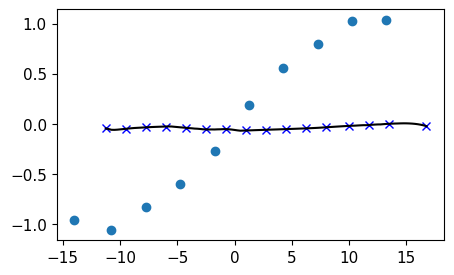

In [272]:
### Data Prepration
import os
import numpy as np
import pandas as pd
import torch

dir_path = os.path.abspath(os.path.dirname(""))
NACA2412 = pd.read_excel(f"{dir_path}/data/NACA2412 Cm over AoA.xlsx").values # .values converts to numpy arrays
NACA0012 = pd.read_excel(f"{dir_path}/data/NACA0012 CL over AoA.xlsx").values
# test = print(torch.from_numpy(NACA0012).shape)
print(len(NACA2412))

# NACA2412 will be the TARGET data that we want to predict which will be the source of HF points
# whereas NACA0012 will be the LF data that will guide us in the MFNN


# The model's aim will be to learn the relationship between AOA and CM (X = AOA, Y = CM)
def tt_split(NACA2412, NACA0012):
    from sklearn.model_selection import train_test_split
    
    X_LF = NACA0012[:,0]
    X_HF = NACA2412[:,0]
    
    X_min = min(min(X_LF), min(X_HF))
    X_max = max(max(X_LF), max(X_HF))
    X = torch.linspace(X_min, X_max, 112).reshape(-1,1)
    
    Y_LF = NACA0012[:,1]
    Y_HF = NACA2412[:,1]
    
    sort_idx = np.argsort(X_LF)
    sorted_x = X_LF[sort_idx]
    sorted_y = Y_LF[sort_idx]

    # Select every k-th point
    k = 12
    
    X_LF_TRAIN = sorted_x[::k]
    Y_LF_TRAIN = sorted_y[::k]
    
    sort_idx = np.argsort(X_HF)
    sorted_x = X_HF[sort_idx]
    sorted_y = Y_HF[sort_idx]

    # Select every k-th point
    k = 7
    
    X_HF_TRAIN = sorted_x[::k]
    X_HF_TRAIN[-1] = X_HF[-1]
    Y_HF_TRAIN = sorted_y[::k]
    Y_HF_TRAIN[-1] = Y_HF[-1]

    # X_LF_TRAIN, X_LF_TEST, Y_LF_TRAIN, Y_LF_TEST = train_test_split(X_LF, Y_LF, test_size=0.3, shuffle=0)
    # X_HF_TRAIN, X_HF_TEST, Y_HF_TRAIN, Y_HF_TEST = train_test_split(X_HF, Y_HF, test_size=0.8, shuffle=0)

    return X_LF_TRAIN, Y_LF_TRAIN, X_HF_TRAIN, Y_HF_TRAIN, X_LF, Y_LF, X_HF, Y_HF,X

X_LF_TRAIN, Y_LF_TRAIN, X_HF_TRAIN, Y_HF_TRAIN, X_LF, Y_LF, X_HF, Y_HF, _ = tt_split(NACA2412, NACA0012) 

X_LF_TRAIN = (X_LF_TRAIN.reshape(-1,1))
Y_LF_TRAIN = (Y_LF_TRAIN.reshape(-1,1))

X_HF_TRAIN = (X_HF_TRAIN.reshape(-1,1))
Y_HF_TRAIN = (Y_HF_TRAIN.reshape(-1,1))



import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,3))
plt.plot(X_HF_TRAIN, Y_HF_TRAIN, "xb")
plt.plot(X_HF,Y_HF, "k")
plt.scatter(X_LF_TRAIN, Y_LF_TRAIN)

# Transfering data to GPU for CUDA
X_LF_TRAIN = torch.from_numpy(X_LF_TRAIN).to(device, dtype=torch.float32); Y_LF_TRAIN = torch.from_numpy(Y_LF_TRAIN).to(device, dtype=torch.float32)

X_HF_TRAIN = torch.from_numpy(X_HF_TRAIN).to(device, dtype=torch.float32); Y_HF_TRAIN = torch.from_numpy(Y_HF_TRAIN).to(device, dtype=torch.float32)
print(X_LF_TRAIN.shape)

Low Fidelity Network

In [273]:
LF_input_dim = 1
LF_output_dim = 1

class LowFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, LF_input_dim, LF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(LF_input_dim, hidden_dims[0])
    # self.bn1 = nn.BatchNorm1d(hidden_dims[0])
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
    self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fc6 = nn.Linear(hidden_dims[4], hidden_dims[5])
    self.fc7 = nn.Linear(hidden_dims[5], hidden_dims[6])
    self.fcEND = nn.Linear(hidden_dims[6], LF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    # skip_connection = xx = x + skip_connection
    # x = self.bn1(x)
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    # x = x + skip_connection
    x = self.fcEND(x)
    return x

LF_model = LowFidelityNetwork(hidden_dims, LF_input_dim, LF_output_dim).to(device)

for param in LF_model.parameters():
    param.requires_grad = True

In [274]:
LF_model.train()

# Training
LF_losses = [] 
val_losses = []
prev_loss = []
LF_loss = torch.zeros(1)

LF_batch_size = 10

# LF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(LF_model.parameters(), lr=0.000003) # weight_decay=1e-5


for epoch in range(lf_num_epochs):
    
    permutation = torch.randperm(X_LF_TRAIN.size()[0])
    
    for i in range(0,X_LF_TRAIN.size()[0], LF_batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+LF_batch_size]
        batch_x, batch_y = X_LF_TRAIN[indices], Y_LF_TRAIN[indices]
    
        prev_loss = LF_loss.item()
        outputs = LF_model.forward(batch_x)
        LF_loss = criterion(outputs,batch_y)
        LF_losses.append(LF_loss.item())
        LF_loss.backward()
        optimizer.step()

    if (epoch+1) % 600 == 0:
        print(f'Epoch [{epoch+1}/{lf_num_epochs}], Loss: {LF_loss.item():.4f}')

Epoch [600/1600], Loss: 0.0091
Epoch [1200/1600], Loss: 0.0013


Epochs needed (out of 1600): 1600
LF Training Loss: 0.00017889631271827966


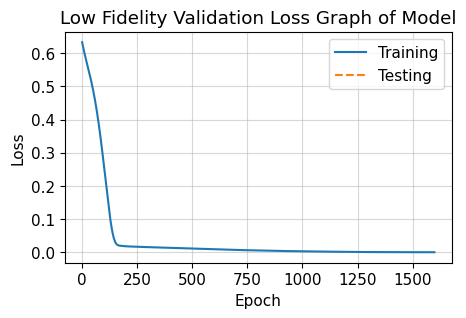

In [275]:
plt.figure(figsize=(5,3))
plt.plot(LF_losses, label = "Training")
plt.xlabel('Epoch')
plt.ylabel('LF_Loss')
plt.title('Low Fidelity Training Loss Graph of Model')

plt.plot(val_losses, "--" , label = "Testing")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Low Fidelity Validation Loss Graph of Model')
plt.grid(which='both', alpha=0.5)
plt.legend(loc='upper right')
# plt.show()

print(f"Epochs needed (out of {lf_num_epochs}): {len(LF_losses)}")
print(f"LF Training Loss: {LF_loss}")

High Fidelity Model

In [276]:
HF_input_dim = 1
HF_output_dim = 1

class HighFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, HF_input_dim, HF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(HF_input_dim, hidden_dims[0])
    self.bn1 = nn.BatchNorm1d(hidden_dims[0])
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
    self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fc6 = nn.Linear(hidden_dims[4], hidden_dims[5])
    self.fc7 = nn.Linear(hidden_dims[5], hidden_dims[6])
    self.fcEND = nn.Linear(hidden_dims[7], HF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = self.bn1(x)
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    x = self.fcEND(x)
    return x

HF_model = HighFidelityNetwork(hidden_dims, HF_input_dim, HF_output_dim).to(device)

for param in HF_model.parameters():
    param.requires_grad = True

In [277]:
HF_model.train()

# Training
HF_losses = [] 
val_losses = []
prev_loss = []
HF_loss = torch.zeros(1)

HF_batch_size = 45

# HF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(HF_model.parameters(), lr=0.000001, weight_decay=1e-5) # weight_decay=1e-5

for epoch in range(hf_num_epochs):
    
    permutation = torch.randperm(X_HF_TRAIN.size()[0])
    
    for i in range(0,X_HF_TRAIN.size()[0], HF_batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+HF_batch_size]
        batch_x, batch_y = X_HF_TRAIN[indices], Y_HF_TRAIN[indices]
    
        prev_loss = HF_loss.item()
        outputs = HF_model.forward(batch_x)
        HF_loss = criterion(outputs,batch_y)
        HF_losses.append(HF_loss.item())
        HF_loss.backward()
        optimizer.step()
        
    if (epoch+1) % 600 == 0:
        print(f'Epoch [{epoch+1}/{hf_num_epochs}], Loss: {HF_loss.item():.4f}')

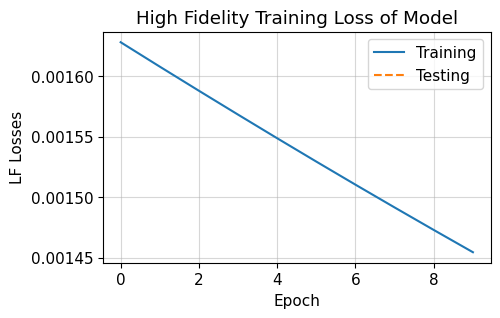

Epochs needed (out of 10): 10
HF Training Loss: 0.00145441060885787


In [278]:
plt.figure(figsize=(5,3))
plt.plot(HF_losses, label = "Training")

plt.plot(val_losses, "--" , label = "Testing")
plt.xlabel('Epoch')
plt.ylabel('LF Losses')
plt.title('High Fidelity Training Loss of Model')
plt.legend(loc='upper right')
plt.grid(which='both', alpha=0.5)
plt.show()

# print(f"Error: {HF_average_percentage_error}")
print(f"Epochs needed (out of {hf_num_epochs}): {len(HF_losses)}")
print(f"HF Training Loss: {HF_loss}")

Multi-Fidelity Model

In [279]:
L1mean = LF_model(X_HF_TRAIN.to(device))

L2train = torch.hstack((X_HF_TRAIN, L1mean)) # think of the house price example (sqr feet, rooms, garden, etc.)
print(L2train.shape)

torch.Size([16, 2])


In [280]:
MF_input_dim  = 2
MF_output_dim = 1

class MultiFidelityNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, MF_input_dim, MF_output_dim):
    super().__init__()
    self.fc1 = nn.Linear(MF_input_dim, hidden_dims[0])
    self.bn1 = nn.BatchNorm1d(hidden_dims[0])
    self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
    self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2])
    self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3])
    self.fc5 = nn.Linear(hidden_dims[3], hidden_dims[4])
    self.fc6 = nn.Linear(hidden_dims[4], hidden_dims[5])
    self.fc7 = nn.Linear(hidden_dims[5], hidden_dims[6])
    self.fcEND = nn.Linear(hidden_dims[6], MF_output_dim)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    # skip_connection = x
    x = self.bn1(x)
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.relu(self.fc5(x))
    x = torch.relu(self.fc6(x))
    x = torch.relu(self.fc7(x))
    # x = x + skip_connection
    x = self.fcEND(x)
    return x

MF_model = MultiFidelityNetwork(hidden_dims, MF_input_dim, MF_output_dim).to(device)

for param in MF_model.parameters():
    param.requires_grad = True

In [281]:
MF_model.train()

# Training
MF_losses = [] 
val_losses = []
prev_loss = []
MF_loss = torch.zeros(1)

# MF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(MF_model.parameters(), lr=0.000001, weight_decay=1e-15) # weight_decay=1e-5

for epoch in range(MF_epochs):

    # Training
    prev_loss = MF_loss.item()
    MF_y_pred = MF_model(L2train)
    MF_loss = criterion(MF_y_pred, Y_HF_TRAIN)
    MF_losses.append(MF_loss.item())
    optimizer.zero_grad()
    MF_loss.backward(retain_graph=True)
    optimizer.step()

    if (epoch+1) % 300 == 0:
        print(f'Epoch [{epoch+1}/{MF_epochs}], Loss: {MF_loss.item():.4f}')

MF Training Loss: 0.00217135576531291


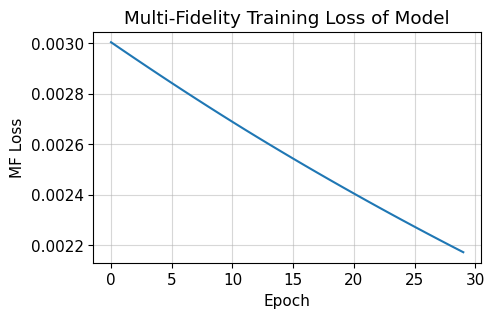

In [282]:
plt.figure(figsize=(5,3))
plt.plot(MF_losses)
plt.xlabel('Epoch')
plt.ylabel('MF Loss')
plt.title('Multi-Fidelity Training Loss of Model')
plt.grid(which='both', alpha=0.5)
print(f"MF Training Loss: {MF_loss}")

In [283]:
# Put models in eval mode
LF_model.eval()
HF_model.eval()
MF_model.eval()

_, _, _, _, X_LF, Y_LF, X_HF, Y_HF, X= tt_split(NACA2412, NACA0012)

X_min = min(X_HF)
X_max = max(max(X_LF), max(X_HF))

X_hefe = torch.linspace(X_min, X_max, 112).reshape(-1,1)
X_lefe = torch.linspace(min(X_LF), max(X_LF), 112).reshape(-1,1)

# Define the NEW input data
with torch.no_grad(): 
    y_LF_pred = LF_model(X_lefe.to(device))
    y_HF_pred = HF_model(X_hefe.to(device)) 
    
    # Step 4: Add X and output of the LF model (similar to Step 2)
    L2test = torch.hstack((X.to(device), y_LF_pred))
    y_MF_pred = MF_model(L2test.to(device)) 

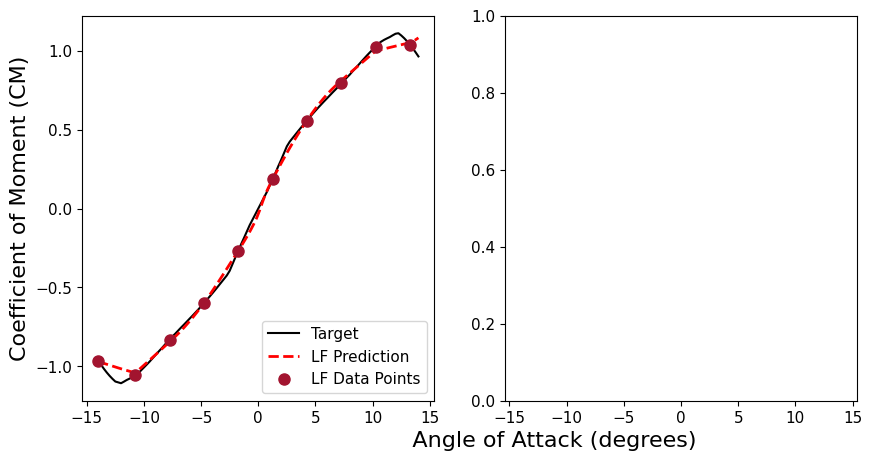

In [284]:
target_width     = 1.5
prediction_width = 2

# Set figure size and axis label font size
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True)
plt.rcParams.update({'font.size': 11})

# Target Line
axs[0].plot(X_LF, Y_LF, "k", label= "Target ", linewidth=target_width)


# Low Fidelity Points and Prediction
axs[0].plot(X_lefe.cpu().detach().numpy(), y_LF_pred.cpu().detach().numpy(),"--r", lw=prediction_width, label= "LF Prediction ",)
axs[0].plot(X_LF_TRAIN.cpu().detach().numpy(), Y_LF_TRAIN.cpu().detach().numpy(), "o", color=(0.6350, 0.0780, 0.1840), markersize = 8, label = 'LF Data Points')
# axs[0].plot(X_hefe.cpu().detach().numpy(), y_HF_pred.cpu().detach().numpy(),"--b", lw=prediction_width, label= "HF Prediction ",)
# axs[0].plot(X_HF_TRAIN.cpu().detach().numpy(), Y_HF_TRAIN.cpu().detach().numpy(), "bo", markersize = 8, label = 'HF Data Points')

# # Multi-Fidelity Prediction
# axs[0].plot(X_HF, Y_HF, "k", linewidth=target_width)
# axs[1].plot(X_HF, Y_HF, "k", linewidth=target_width)
# axs[1].plot(X.cpu().detach().numpy(), y_MF_pred.cpu().detach().numpy(),"--", color=(0.5,0.3, 0.8), lw=4, label= "MF Prediction ",)

# Set axis labels and titles
axs[0].set_xlabel('                                                                                   Angle of Attack (degrees)', fontsize=16)
axs[0].set_ylabel('Coefficient of Moment (CM)', fontsize=16)


# Add legends and gridlines
axs[0].legend(loc='lower right', fontsize= 11)

# Show the plot*0*0
plt.show()